In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from keras.datasets import reuters
from keras import models
from keras import layers

# 1. Load reuters dataset

In [3]:
np_old_load = np.load
np.load = lambda *a, **k: np_old_load(*a, **k, allow_pickle = 'True')

In [4]:
n_most_words = 10000
(X_train, Y_train), (X_test, Y_test) = reuters.load_data(num_words = n_most_words)

In [5]:
np.load = np_old_load
del np_old_load

In [6]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(8982,) (8982,)
(2246,) (2246,)


In [6]:
len(X_train) + len(X_test)

11228

# 2. Explore and encode data

In [7]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])
decoded_newires = ' '.join([reverse_word_index.get(i-3,'?') for i in X_train[0]])
decoded_newires

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [8]:
def vectorize_sequences(sequences, dimension = 10000):
    results = np.zeros((len(sequences),dimension))
    for i, sequence in enumerate(sequences):
        results[i,sequence] = 1
    return results
# can use np.eye

In [9]:
X_train = vectorize_sequences(X_train)
X_test = vectorize_sequences(X_test)

In [10]:
def to_one_hot(labels, dimension = 46):
    results = np.eye(dimension)[labels]
    return results
# we can code to_one_hot which is similar to vectorize_sequences
#def to_one(labels, dimension=46):
#    results = np.zeros((len(labels), dimension))
#    for i, label in enumerate(labels):
#        results[i, label] = 1.
#    return results

In [11]:
Y_train_one_hot = to_one_hot(Y_train)
Y_test_one_hot = to_one_hot(Y_test)

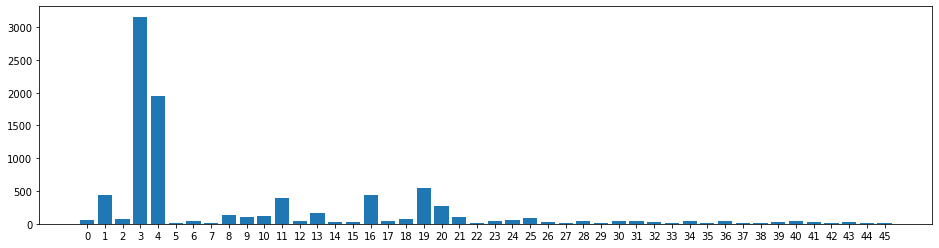

In [12]:
plt.figure(figsize = (16, 4))
plt.bar([i for i in range(0, 46)], np.sum(Y_train_one_hot, axis = 0), align = 'center')
plt.xticks([i for i in range(0, 46)])
plt.show()

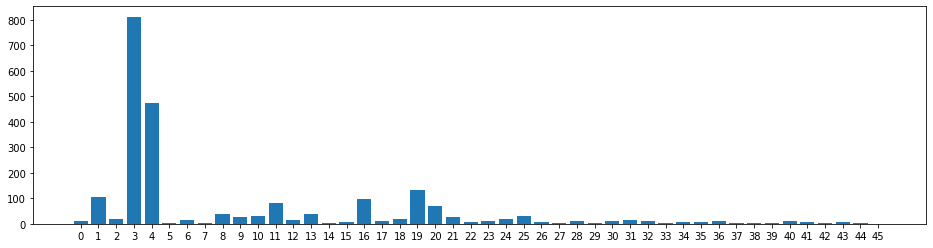

In [13]:
plt.figure(figsize = (16, 4))
plt.bar([i for i in range(0, 46)], np.sum(Y_test_one_hot, axis = 0), align = 'center')
plt.xticks([i for i in range(0, 46)])
plt.show()

# 3. Constuct deep model to train, validate, and test

In [14]:
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape =(X_train.shape[1],)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(46, activation = 'softmax'))

In [15]:
model.compile(optimizer = 'rmsprop',loss ='categorical_crossentropy',metrics = ['accuracy'])

In [16]:
X_validation = X_train[0:1000]
Y_validation = Y_train_one_hot[0:1000]
Partial_X_train = X_train[1000:]
Partial_Y_train = Y_train_one_hot[1000:]

In [17]:
fitedModel = model.fit(Partial_X_train, Partial_Y_train,epochs=20,batch_size=512, validation_data=(X_validation,Y_validation))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 42s 5ms/step - loss: 2.5318 - acc: 0.4959 - val_loss: 1.7205 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 3s 428us/step - loss: 1.4465 - acc: 0.6883 - val_loss: 1.3479 - val_acc: 0.7070
Epoch 3/20
7982/7982 [==============================] - 2s 241us/step - loss: 1.0971 - acc: 0.7646 - val_loss: 1.1732 - val_acc: 0.7440
Epoch 4/20
7982/7982 [==============================] - 2s 224us/step - loss: 0.8709 - acc: 0.8147 - val_loss: 1.0799 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 2s 222us/step - loss: 0.7046 - acc: 0.8472 - val_loss: 0.9858 - val_acc: 0.7790
Epoch 6/20
7982/7982 [==============================] - 2s 274us/step - loss: 0.5687 - acc: 0.8787 - val_loss: 0.9415 - val_acc: 0.8020
Epoch 7/20
7982/7982 [==============================] - 2s 219us/step - loss: 0.4611 - acc: 0.9030 - val_loss: 0.9072 - val_acc: 0.8010
E

In [18]:
history = fitedModel.history
history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

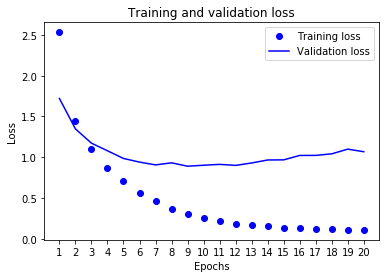

In [19]:
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

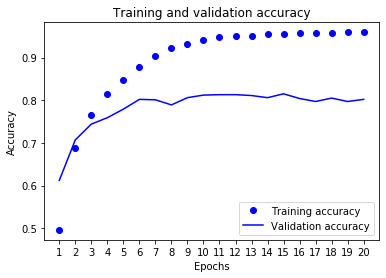

In [20]:
plt.clf()
acc = history['acc']
val_acc = history['val_acc']
plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### From the two above figures, one can see epochs = 9 is the best set up. Thus, we construct a new model with that epoch

In [21]:
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape =(X_train.shape[1],)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(46, activation = 'softmax'))

In [22]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [23]:
model.fit(Partial_X_train,Partial_Y_train,epochs=9,batch_size=512,validation_data=(X_validation, Y_validation))

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 3s 398us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 2s 222us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 2s 222us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/9
7982/7982 [==============================] - 2s 222us/step - loss: 0.7975 - acc: 0.8251 - val_loss: 1.0538 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 2s 222us/step - loss: 0.6392 - acc: 0.8627 - val_loss: 0.9749 - val_acc: 0.7920
Epoch 6/9
7982/7982 [==============================] - 2s 226us/step - loss: 0.5123 - acc: 0.8921 - val_loss: 0.9101 - val_acc: 0.8120
Epoch 7/9
7982/7982 [==============================] - 2s 219us/step - loss: 0.4122 - acc: 0.9137 - val_loss: 0.8922 - val_acc: 0.8210
Epoch 8

In [24]:
results = model.evaluate(X_test, Y_test_one_hot)
results

2246/2246 [==============================] - 1s 243us/step


[1.0238676190057825, 0.7751558326443496]

#### we see that loss and accuracy on test aprroxiamte 1.02 and 0.78, respectively. Next, we check accuracy from random model

In [25]:
Y_test_copy = Y_test.copy()
np.random.shuffle(Y_test_copy)
sum(Y_test_copy == Y_test)/len(Y_test)

0.182546749777382

#### The deep model is very better than random model.

In [26]:
Y_test_probs = model.predict(X_test)
Y_test_probs.shape

(2246, 46)

In [27]:
Y_test_hat = np.argmax(Y_test_probs, axis = 1)
Y_test_hat.shape

(2246,)

In [28]:
columns = [str(i) for i in range(0, 46)]
cfm = confusion_matrix(Y_test, Y_test_hat)
cfm_normalized = pd.DataFrame(cfm / np.sum(cfm, axis = 1), columns = columns)

In [29]:
np.diagonal(cfm_normalized)

array([0.58333333, 0.8       , 0.65      , 0.95448954, 0.8185654 ,
       0.        , 0.92857143, 0.33333333, 0.63157895, 0.68      ,
       0.8       , 0.62650602, 0.07692308, 0.56756757, 0.        ,
       0.11111111, 0.80808081, 0.16666667, 0.6       , 0.70676692,
       0.5       , 0.7037037 , 0.        , 0.25      , 0.21052632,
       0.67741935, 0.75      , 0.25      , 0.1       , 0.25      ,
       0.25      , 0.46153846, 0.6       , 0.6       , 0.57142857,
       0.        , 0.54545455, 0.        , 0.33333333, 0.        ,
       0.        , 0.125     , 0.33333333, 0.83333333, 0.8       ,
       0.        ])

In [30]:
print(classification_report(Y_test, Y_test_hat, target_names=[str(i) for i in range(0, 46)]))

              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.58      0.80      0.67       105
           2       0.76      0.65      0.70        20
           3       0.85      0.95      0.90       813
           4       0.89      0.82      0.85       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.71      0.63      0.67        38
           9       0.85      0.68      0.76        25
          10       0.96      0.80      0.87        30
          11       0.57      0.63      0.59        83
          12       0.20      0.08      0.11        13
          13       0.64      0.57      0.60        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0.62      0.81      0.70        99
          17       1.00    

C:\Users\binht\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\binht\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\binht\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### The above warning implies that some values in Y_test don't appear in Y_test_hat.